#  Градиентный бустинг

#### Catboost vs. LightGBM vs. XGBoost

*  Сравнение моделей на искусственном примере
*  CatBoost для решения задачи
*  Интерпретация модели
*  Блендинг и стекинг

В прошлый раз мы посмотрели простую версию градиентного бустинга из scikit-learn, [придуманную в 1999 году Фридманом](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451). Прогресс не стоит на месте, и на сегодняшний день есть три популярные библиотеки с разными имплементациями градиентного бустинга, которые на практике показывают лушие результаты: 
*  **XGBoost**. Появилась в 2014 году, [статья автора](https://mran.microsoft.com/snapshot/2020-07-15/web/packages/xgboost/vignettes/xgboost.pdf) вышла в 2016. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Об особенностях данной библиотеки рассказывалось на лекции.
* **CatBoost** от компании Яндекс с релизом в 2017 году. Алгоритм можно запускать с дефолтными гиперпараметрами, потому тчо он является менее чувствительным к выбору их конкретных значений. Отлично умеет работать с категориальным признаками, при этом автоматически обрабатывая полученные на вход непредобработанные фичи. 
* **LightGBM**. Релиз в один год с Catboost, библиотека от Microsoft. Отличается очень быстрым построением композиции. Например, при построении узла дерева, вместо перебора по всем значениям признака, производится перебор значений гистограммы этого признака. Таким образом, вместо $O(N)$ требуется $O$(m), где $m$ - число бинов гистограммы. В отличие от других библиотек, строит деревья в глубину, при этом на каждом шаге строит вершину, дающую наибольшее уменьшение функционала.



|Критерий|Catboost|Lightgbm|Xgboost|
|--|--|--|--|
|Год релиза|2014|2017|2017|
|Построение деревьев|симметрично по уровням|в глубину|асимметрично по уровням до максимальной глубины с прунингом|
|Параметры контроля переобучения|learning_rate, depth, l2-leaf-reg (аналога min_child_weigth нет) |learning_rate, max_depth, num_leaves, min_data_in_leaf|learning_rate (eta), min_child_weigth, max_depth|
|Контроль скорости обучения|rsm, iterations|feature_fraction, bagging_fraction, num_iterations|n_estimator, colsample_bytree, subsample|
|Параметры категориальных фичей|cat_features, one_hot_max_size|categorical_feature|не доступно|
|Бинаризация признаков|сетка выбирается заранее|-|перебор всех границ, выбор сетки на каждой итерации|
|Скор сплита|Похожесть векторов градиентов |-| Смотрим на изменение функции ошибки|
|Bootstrap|Можно перевзвешивать и менять интенсивность |-|-|
|Рандомизация скора сплита|+ |-|-|


### Основные параметры

* objective – функция ошибки для настройки композиция
* learning_rate / eta – скорость обучения
* n_estimators / num_iterations – число итераций градиентного бустинга

### Настройка сложности деревьев

* max_depth – максимальная глубина 
* max_leaves / num_leaves – максимальное число вершин в дереве
* gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
* min_data_in_leaf – минимальное число объектов в листе
* min_sum_hessian_in_leaf – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление 
* lambda – коэффициент регуляризации (L2)
* subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева 
* colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева 

Начать настройку можно с самых главных параметров: learning_rate и n_estimators. Один из них фиксируем, оставшийся из этих двух параметров подбираем (например, подбираем скорость обучения при n_estimators=100). Следующий параметр по важности - max_depth, так как мы хотим неглубокие деревья (в Catboost и LightGBM) для снижения переобучения.



**Техническое отступление**

Данные библиотеки необходимо сначала устанавливать (можно через pip / conda или brew, если Вы работаете на MAC OS).
Чтобы у Вас точно вопроизводился ноутбук и не было проблем из-за несовпадающих версий библиотек, рекомендуется через python создавать виртуальную среду. Подробнее см. файлики ```техническое_отступление.md``` и ```requirements.txt```. 

В текущем ноутбуке использовались следующие версии библиотек: 

In [2]:
!pip install catboost==1.0.3
!pip install lightgbm==3.2.1
!pip install cmake==3.22.0 # без нее xgboost установится, но не будет импортироваться
!pip install xgboost==1.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.3 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.8 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 660 kB/s 
  Attempting uninstall: cmake
    Found existing installation: cmake 3.22.6
    Uninstalling cmake-3.22.6:
      Successfully uninstalled cmake-3.22.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173.5 MB 61 kB/s 
  Attempting uninstall: xgboost
    Found existing installati

In [3]:
import warnings
warnings.filterwarnings('ignore')

import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost

plt.rcParams["figure.figsize"] = (8, 5)

## Catboost и другие бустинги для искусственного примера

В алгоритме сделаны улучшения и выбор разных опций для борьбы с переобучением, подсчету сркднего таргета на отложенной выборке, подсчету статистик по категориальным фичам, бинаризацией фичей, рандомизации скора сплита, разные типы бутсрапирования. 

Давайте сначала зафиксируем все гиперпараметры со значениями по умолчанию, кроме количества деревьев в композиции - `n_estimators`. 

In [ ]:
def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график сами наблюдения
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

0.919452347083926


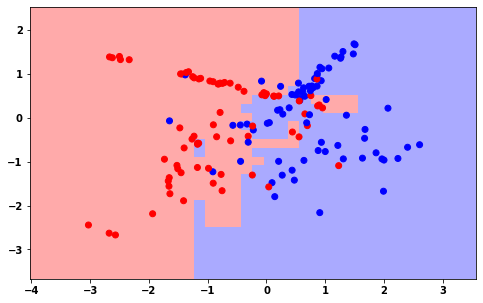

In [ ]:
from catboost import CatBoostClassifier 

catboost = CatBoostClassifier(n_estimators=300, logging_level='Silent')
catboost.fit(X_train, y_train)
plot_surface(X_test, y_test, catboost)

print(roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1]))

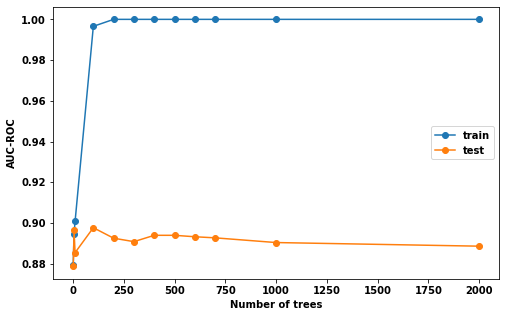

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000]
quals_train = []
quals_test = []
for n in n_trees:
    catboost = GradientBoostingClassifier(n_estimators=n)
    catboost.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

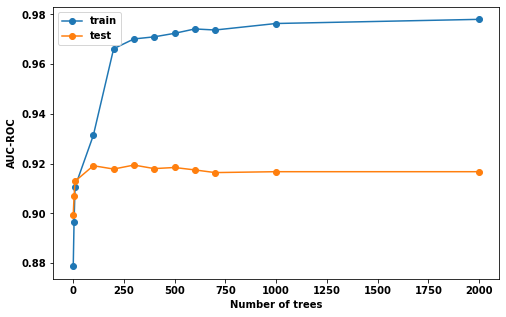

In [ ]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000]
quals_train = []
quals_test = []
for n in n_trees:
    catboost = CatBoostClassifier(iterations=n, logging_level='Silent')
    catboost.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

## Xgboost

1. Базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

2. Функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

3. При построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

4. Критерий останова при обучении дерева также зависит от оптимального сдвига

Ссылка на [источник](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/lecture-notes/lecture11-ensembles.pdf)

0.8745554765291608


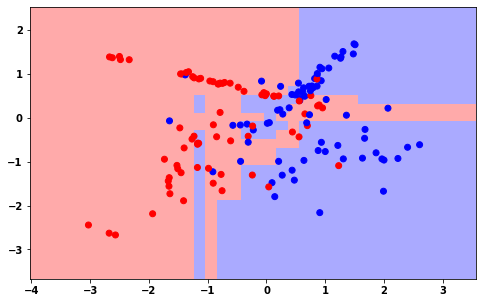

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300, verbosity=0)
xgb.fit(X_train, y_train)
plot_surface(X_test, y_test, xgb)

print(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

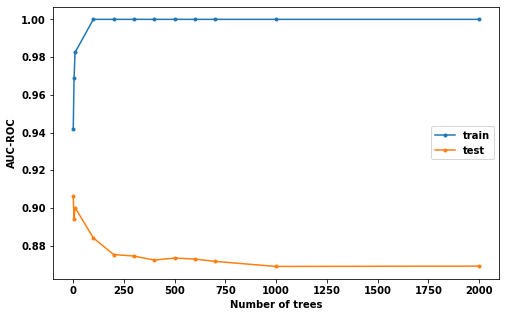

In [ ]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000]
quals_train = []
quals_test = []
for n in n_trees:
    xgboost = XGBClassifier(n_estimators=n, verbosity=0)
    xgboost.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, xgboost.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, xgboost.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Видно, что переобучились - качество на тесте только падает.

## LightGBM

0.8733108108108107


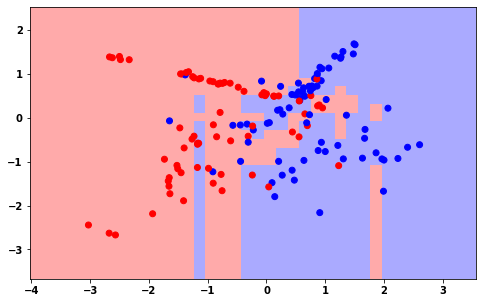

In [ ]:
from lightgbm import LGBMClassifier

lightgbm = LGBMClassifier(n_estimators=300)
lightgbm.fit(X_train, y_train)
plot_surface(X_test, y_test, lightgbm)

print(roc_auc_score(y_test, lightgbm.predict_proba(X_test)[:, 1]))

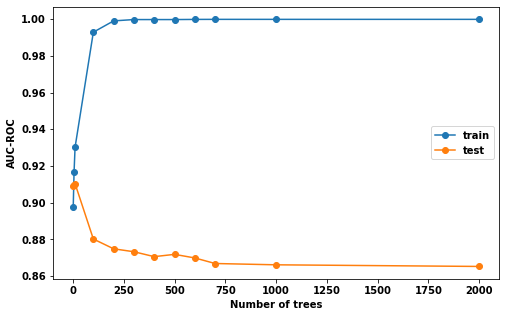

In [ ]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700, 1000, 2000]
quals_train = []
quals_test = []
for n in n_trees:
    lightgbm = LGBMClassifier(n_estimators=n)
    lightgbm.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lightgbm.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lightgbm.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

В целом, у LightGBM получилась та же проблема с переобучением, как у Xgboost. Нужно дальше подбирать гиперпараметры для этих двух.

Попробуем взять фиксированное количество деревьев `n_estimators`, но будем менять их максимальную глубину `max_depth`. У этих алгоритмов разное время обучения, поэтому возьмем какой-то небольшой диапазон глубины и сравним все три модели - Catboost, LightGBM, Xgboost.

In [ ]:
def plot_model_diff_depths(model=LGBMClassifier, depth_range=list(range(1, 5)), n_trees=10):
    roc_auc_train = []
    roc_auc_test = []
    for i in depth_range:
        clf = model(n_estimators=n_trees, max_depth=i)
        if type(clf) == type(CatBoostClassifier()):
            clf = CatBoostClassifier(n_estimators=n_trees, max_depth=i, logging_level="Silent")
        clf.fit(X_train, y_train)
        q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
        q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        roc_auc_train.append(q_train)
        roc_auc_test.append(q_test)

    plt.figure(figsize=(7, 5))
    plt.plot(depth_range, roc_auc_train, marker='o', label='train')
    plt.plot(depth_range, roc_auc_test, marker='o', label='test')
    plt.title(f'{model}')
    plt.xlabel('Depth')
    plt.ylabel('AUC-ROC')
    plt.legend()

    plt.show()

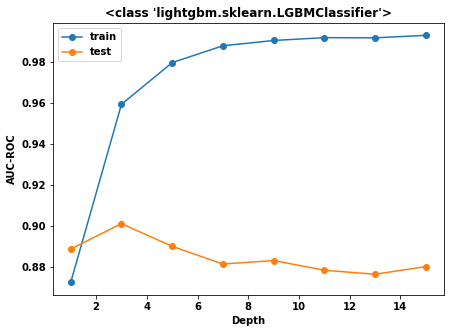

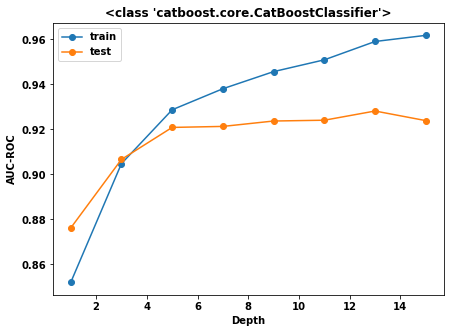

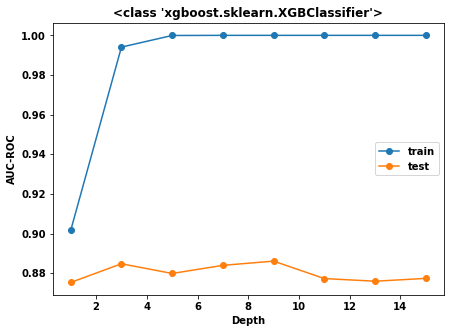

In [ ]:
plot_model_diff_depths(model=LGBMClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)
plot_model_diff_depths(model=CatBoostClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)
plot_model_diff_depths(model=XGBClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)

Когда мы обучили лучшие версии моделей, можно их сохранить и использовать для получения предсказаний, например, на новом батче данных. 

In [ ]:
# Сохранить
lightgbm.booster_.save_model('lightgbm.txt')
catboost.save_model('catboost.cbm', format='cbm')
xgboost.save_model('xgboost.json')

# Загрузить
lightgbm = LGBMClassifier(model_file='mode.txt')
catboost = catboost.load_model('catboost.cbm')
xgboost = xgboost.load_model('xgboost.json')

## Catboost для решения задачи + интерпретация признаков

In [19]:
data = pd.read_csv("bike_buyers_clean.csv")

In [20]:
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes


In [21]:
X = data.drop(['ID','Purchased Bike'], axis=1)
y = data['Purchased Bike']

In [22]:
X.head()

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
0,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42
1,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43
2,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60
3,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41
4,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36


In [23]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=42)

In [70]:
from catboost import CatBoostClassifier

model1 = CatBoostClassifier(cat_features = [0, 1, 4, 5, 6, 8, 9]),  # one_hot_max_size=10)
model1.fit(Xtrain, ytrain)

Learning rate set to 0.007663
0:	learn: 0.6908782	total: 725us	remaining: 725ms
1:	learn: 0.6897559	total: 1.33ms	remaining: 662ms
2:	learn: 0.6872643	total: 2.13ms	remaining: 708ms
3:	learn: 0.6855959	total: 2.96ms	remaining: 738ms
4:	learn: 0.6839733	total: 3.81ms	remaining: 758ms
5:	learn: 0.6827635	total: 4.63ms	remaining: 768ms
6:	learn: 0.6809835	total: 5.73ms	remaining: 813ms
7:	learn: 0.6802245	total: 6.49ms	remaining: 805ms
8:	learn: 0.6788992	total: 7.36ms	remaining: 811ms
9:	learn: 0.6773087	total: 8.25ms	remaining: 816ms
10:	learn: 0.6760143	total: 9.14ms	remaining: 822ms
11:	learn: 0.6745937	total: 10.1ms	remaining: 835ms
12:	learn: 0.6728281	total: 11ms	remaining: 839ms
13:	learn: 0.6711055	total: 11.9ms	remaining: 842ms
14:	learn: 0.6696310	total: 12.8ms	remaining: 843ms
15:	learn: 0.6683182	total: 13.7ms	remaining: 844ms
16:	learn: 0.6672679	total: 14.6ms	remaining: 847ms
17:	learn: 0.6654243	total: 15.5ms	remaining: 846ms
18:	learn: 0.6642317	total: 16.4ms	remaining: 8

In [71]:
from sklearn.metrics import accuracy_score

pred = model1.predict(Xtest)

accuracy_score(ytest, pred)

0.686

In [72]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : np.arange(10,20,3),
          'learning_rate' : [0.01, 0.05, 0.1],
          'one_hot_max_size' : [10, 50, 100]}

gs = GridSearchCV(CatBoostClassifier(n_estimators=100, cat_features = [0, 1, 4, 5, 6, 8, 9], verbose=0), params, cv=3, scoring='accuracy', verbose=2)

gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=10; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=10; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=10; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=50; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=50; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=50; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=10, one_hot_max_size=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=13, one_hot_max_size=10; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=13, one_hot_max_size=10; total time=   0.8s
[CV] END learning_rate

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f56b65fcdf0>,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': array([10, 13, 16, 19]),
                         'one_hot_max_size': [10, 50, 100]},
             scoring='accuracy', verbose=2)

In [73]:
gs.best_score_, gs.best_params_

(0.6980496837650002,
 {'learning_rate': 0.01, 'max_depth': 13, 'one_hot_max_size': 10})

## Оценка важности признаков

[Статья](https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed)

In [59]:
from sklearn.metrics import log_loss

def logloss(model, X, y): 
    return log_loss(y, model.predict_proba(X)[:,1])

def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

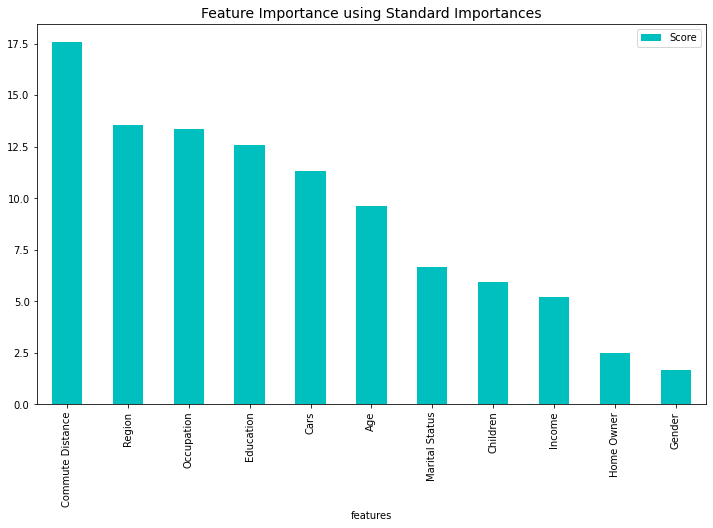

In [63]:
fi_1 = model1.feature_importances_

feature_score = pd.DataFrame(list(zip(Xtest.dtypes.index, fi_1)),
                                    columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format('Standard Importances'), fontsize = 14)
ax.set_xlabel("features")
plt.show()

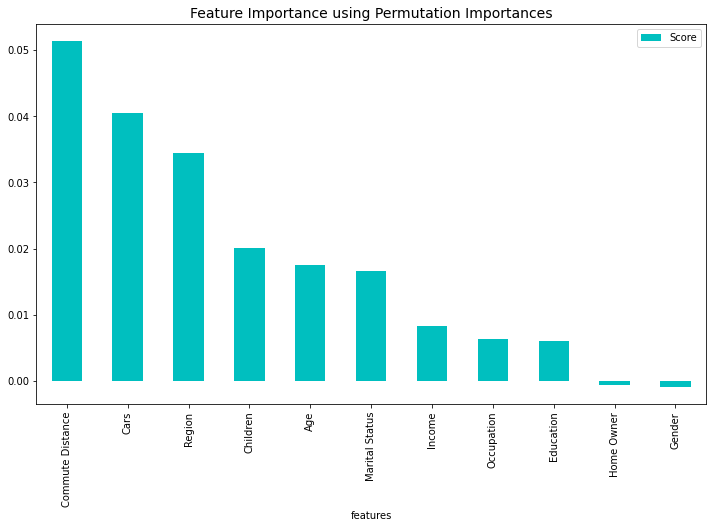

In [64]:
fi_2 = permutation_importances(model1, Xtest, ytest, logloss)
    
feature_score = pd.DataFrame(list(zip(Xtest.dtypes.index, fi_2)),
                                    columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format('Permutation Importances'), fontsize = 14)
ax.set_xlabel("features")
plt.show()

## Блендинг и стекинг

В этом подходе предсказания строятся как взвешенная сумма базовых алгоритмов. 

Рассмотрим простой пример блендинга градиентного бустинга и линейной регрессии для датасете `load_boston` и оценкой качества через RMSE.

Поделим выборку на обучающую (60%), тестовую (20%) и валидационную (20%). 

In [ ]:
from sklearn.datasets import load_boston

data = load_boston()
X_init = pd.DataFrame(data.data, columns=data.feature_names)
y_init = data.target

X, X_test, y, y_test = train_test_split(X_init, y_init, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

assert X_init.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

Посмотрим, какое у нас качество у алгоритмов, если просто обучим на train и проверим качество на test:

In [ ]:
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)
test_pred_cbm = cbm.predict(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
test_pred_lr = lr.predict(X_test)

print("Test RMSE Linear Regression = %.3f" % rmse(y_test, test_pred_lr))
print("Test RMSE Catboost = %.3f" % rmse(y_test, test_pred_cbm))

pred = 0.7 * test_pred_lr + 0.3 * test_pred_cbm

print("Test RMSE mix = %.3f" % rmse(y_test, pred))

Test RMSE Linear Regression = 5.030
Test RMSE Catboost = 5.706
Test RMSE mix = 4.602


Представим новый алгоритм $a(x)$ как взвешенную сумму из базовых алгоритмов:
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
где $\sum_{n} w_n =1$ и нам нужно подобрать $w_n$. 

Сначала рассмотрим более простой случай, когда пробуем подбирать, с какими весами нам взять предсказания алгоритмов методом перебора пар весов (т.к. у нас только два алгоритма). 

Будем веса подбирать на валидации, а проверять качество на тесте.

In [ ]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric

In [ ]:
val_pred_cbm = cbm.predict(X_val)
val_pred_lr = lr.predict(X_val)

rmse_blending_train, w_0, w_1 = min(select_weights(y_val, val_pred_cbm, val_pred_lr), key=lambda x: x[0])
rmse_blending_train, w_0, w_1 

(4.572981570798132, 0.2552552552552553, 0.7447447447447447)

In [ ]:
round(rmse(y_test, test_pred_cbm * w_0 +  test_pred_lr * w_1), 3)

4.631

В данном случае видно, что нам с помощью блендинга с весами примерно 26% из градиентного бустинга и 74% из линейной регрессии удалось снизить ошибку на тесте до 4.63. 

Давайте теперь напишем классическую версию блендинга, который выполняется по следующей схеме. Возьмем обучающую и тестовую выборку и разделим обучающую выборку на две части. На первой части обучим базовые алгоритмы, на второй - обучим мета-алгоритм из предсказаний базовых алгоритмов, и потом получим предсказания тестовых мета-признаках. 
<img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking.png?w=1400' width=600>

Посмотрим на все шаги с самого начала, c момента загрузки исходных данных:

In [ ]:
data = load_boston()
X_init = pd.DataFrame(data.data, columns=data.feature_names)
y_init = data.target

X, X_test, y, y_test = train_test_split(X_init, y_init, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

assert X_init.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

In [ ]:
from lightgbm import LGBMRegressor

gb = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
gb.fit(X_train, y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

meta_train_df = pd.DataFrame()
meta_train_df['gb_preds'] = gb.predict(X_val)
meta_train_df['lr_preds'] = lr.predict(X_val)

meta_algo = LGBMRegressor()
meta_algo.fit(meta_train_df, y_val)

meta_pred_df = pd.DataFrame()
meta_pred_df['gb_preds'] = gb.predict(X_test)
meta_pred_df['lr_preds'] = lr.predict(X_test)
test_preds_meta = meta_algo.predict(meta_pred_df)

rmse(y_test, test_preds_meta)

4.848084651946907

Получается, что при блендинге базовые алгоритмы и мета-алгоритм не используют весь объем выборки обучения, что является недостатком. Для повышения качества нужно усреднять несколько блендигов.

### Стэкинг

Попробуем реализовать стэкинг. Выборку разбивают на два фолда, последовательно перебирая фолды, обучают базовые алгоритмы на всех фолдах, кроме одного, а на оставшемся получают ответы базовых алгоритмов и используют их как значения соответствующих признаков на этом фолде. Для получения мета-признаков объектов тестовой выборки базовые алгоритмы обучают на всей обучающей выборке и берут их ответы на тестовой.

<img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking-2b.png?w=1400' width=600>

Для стэкинга можно пользоваться встроенной имплементацией в sklearn. Возьмем случайный лес и линейную регрессию как базовые алгоритмы, и потом обучим поверх с помощью 10-фолдовой кросс-валидации мета-алгоритм - градиентный бустинг.

In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

estimators = [('rf', RandomForestRegressor(n_estimators=200,random_state=42)),
              ('lr', LinearRegression(),
               'knn',KNeighborsClassifier(n_neighbors=10))]

reg = StackingRegressor(estimators=estimators,
                        cv=10,
                        final_estimator=CatBoostRegressor(iterations=700, max_depth=5, learning_rate=0.01, 
                                       loss_function='RMSE', logging_level='Silent'))

reg.fit(X_train, y_train).score(X_test, y_test)
reg_preds = reg.predict(X_test)
round(rmse(y_test, reg_preds), 3)

3.315